In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats

# Part A

## Dataset Preprocessing

In [2]:
if os.path.exists("nonstopflights.csv"):
    df = pd.read_csv("nonstopflights.csv")
else:
    df = pd.read_table("split_00.txt", sep=",")
    
    # considering only non-stop flights
    df = df[df["isNonStop"] == True]
    df.to_csv("nonstopflights.csv", index=False)

In [3]:
# Dataset listing the distance, duration, airline, and airplane type
df = df[["totalTravelDistance", "travelDuration", "segmentsAirlineName", "segmentsEquipmentDescription"]]

In [4]:
df

,totalTravelDistance,travelDuration,segmentsAirlineName,segmentsEquipmentDescription
0,725.0,PT2H23M,American Airlines,Airbus A321
1,541.0,PT1H51M,United,Embraer 175 (Enhanced Winglets)
2,1919.0,PT4H43M,Delta,Airbus A321
3,762.0,PT2H9M,Frontier Airlines,NaN
4,762.0,PT2H19M,American Airlines,Embraer 175
...,...,...,...,...
1104637,1115.0,PT2H40M,American Airlines,Boeing 787-8
1104638,1115.0,PT2H50M,American Airlines,Boeing 737-800
1104639,799.0,PT2H20M,American Airlines,Boeing 737-800
1104640,799.0,PT2H35M,United,Boeing 737 MAX 9


In [5]:
# Convert travel duration from PTxHyM format to hours
def convertTravelDurationToHours(x):
    x = re.sub(r"PT(?:(\d+)H)?(?:(\d+)M)?", r"\1,\2", x).split(",")
    if not x[0]:
        return float(x[1])/60
    if not x[1]:
        return float(x[0])
    return float(x[0]) + float(x[1])/60
df["travelDuration"] = df["travelDuration"].map(lambda x: convertTravelDurationToHours(x))

In [6]:
# Add a new column called "speed"
df["speed"] = df["totalTravelDistance"] / df["travelDuration"]  # miles/hour

If two rows are identical, then no new information is provided; therefore, we should just count repeated rows once.

If two rows are nearly identical, then we can just take the average of the two rows, since the differences could be due to random factors.

In [7]:
df.drop_duplicates()

,totalTravelDistance,travelDuration,segmentsAirlineName,segmentsEquipmentDescription,speed
0,725.0,2.383333,American Airlines,Airbus A321,304.195804
1,541.0,1.850000,United,Embraer 175 (Enhanced Winglets),292.432432
2,1919.0,4.716667,Delta,Airbus A321,406.855124
3,762.0,2.150000,Frontier Airlines,NaN,354.418605
4,762.0,2.316667,American Airlines,Embraer 175,328.920863
...,...,...,...,...,...
1104514,NaN,2.383333,United,Boeing 777,NaN
1104538,NaN,3.250000,United,Boeing 737-900,NaN
1104539,NaN,3.166667,United,Boeing 737-700,NaN
1104545,761.0,2.583333,Delta,Boeing 757-200,294.580645


## Examine the probability distribution of the speeds

<Axes: xlabel='speed', ylabel='Count'>

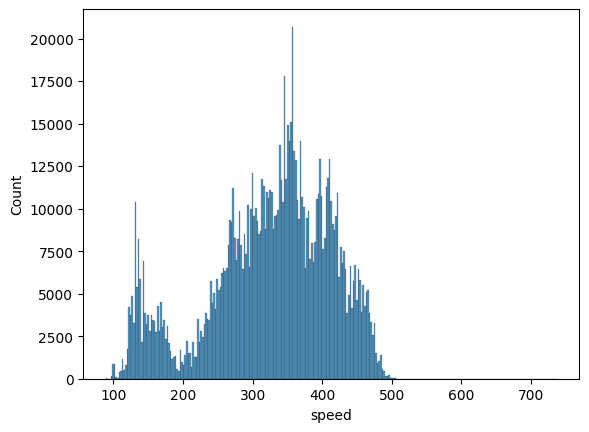

In [8]:
sns.histplot(df, x="speed")

The speeds follow some sort of bimodal distribution, with a peak at around 125 mph and a peak at 350 mph.

### Check whether speeds of Boeing 737-800 ~ Normal(sample_mean, sample_std)

In [9]:
# Filter out speeds for the Boeing 737-800
boeing_speeds = df[df["segmentsEquipmentDescription"] == "Boeing 737-800"]["speed"].sort_values().reset_index(drop=True)
boeing_speeds = boeing_speeds.dropna()  # drop na values
boeing_speeds

0         113.265306
1         113.265306
2         113.265306
3         113.265306
4         113.265306
             ...    
209907    481.468531
209908    481.468531
209909    488.456376
209910    736.818182
209911    736.818182
Name: speed, Length: 209912, dtype: float64

In [10]:
def eCDF(x, F):
    # Returns the value of Fhat_X(x), given the eCDF
    # binary search for the correct value of Fhat_X(x)
    l, r = 0, len(F)-1
    m = (l + r) // 2
    while l <= r:
        m = (l + r) // 2
        if F[m][0] < x:
            l = m + 1
        elif F[m][0] > x:
            r = m - 1
        else:
            return F[m][1]
    if F[m][0] < x:
        return F[m][1]
    else:
        if m-1 >= 0:
            return F[m-1][1]
        else:
            return 0

def kstest(x, m, s):
    # Check if x follows a normal distribution with mean m and standard deviation s
    norm_dist = stats.norm(loc=m, scale=s)
    norm_cdf = []
    ecdf = []
    for i in range(len(x)):
        norm_cdf.append(norm_dist.cdf(x[i]))
        ecdf.append((x[i], (i+1)/len(x)))
    left_ecdf = [eCDF(i-0.1, ecdf) for i in x]
    right_ecdf = [eCDF(i+0.1, ecdf) for i in x]
    diff_left = [abs(i - j) for i, j in zip(norm_cdf, left_ecdf)]
    diff_right = [abs(i - j) for i, j in zip(norm_cdf, right_ecdf)]
    KS_statistic = max(max(diff_left), max(diff_right))
    return KS_statistic

In [11]:
# K-S test to check whether the Boeing 737-800 speeds follow a normal distribution
ks = kstest(boeing_speeds, boeing_speeds.mean(), boeing_speeds.std())
print(ks)

0.08687100035524492


Since D=0.0868 > c=0.05, we reject the null hypothesis that boeing speeds follow a normal distribution with mean = sample mean and standard deviation = sample standard deviation.

### Check whether speeds of Delta flights ~ Normal(sample_mean, sample_std)

In [12]:
# Filter out speeds for Delta
delta_speeds = df[df["segmentsAirlineName"] == "Delta"]["speed"].sort_values().reset_index(drop=True)
delta_speeds = delta_speeds.dropna()  # drop na values
delta_speeds

0         100.909091
1         101.834862
2         101.834862
3         101.834862
4         101.834862
             ...    
241984    487.881356
241985    488.497854
241986    488.497854
241987    488.497854
241988    490.804598
Name: speed, Length: 241989, dtype: float64

In [13]:
# K-S Test to check whether airline Delta speeds follow a normal distribution
ks = kstest(delta_speeds, delta_speeds.mean(), delta_speeds.std())
print(ks)

0.07084629161352513


Since D=0.0708 > c=0.05, we reject the null hypothesis that Delta speeds follow a normal distribution with mean = sample mean and standard deviation = sample standard deviation.

### Check if speeds for Boeing 737-800 $\overset{d}{=}$ speeds for Boeing 737-900

In [14]:
def kstest_twosample(x, y):
    ecdfx, ecdfy = [], []
    for i in range(len(x)):
        ecdfx.append((x[i], (i+1)/len(x)))
    for i in range(len(y)):
        ecdfy.append((y[i], (i+1)/len(y)))
    left_ecdfx = [eCDF(i-0.1, ecdfx) for i in x]
    right_ecdfx = [eCDF(i+0.1, ecdfx) for i in x]
    left_ecdfy = [eCDF(i-0.1, ecdfy) for i in y]
    right_ecdfy = [eCDF(i+0.1, ecdfy) for i in y]
    diff_left = [abs(i - j) for i, j in zip(left_ecdfx, left_ecdfy)]
    diff_right = [abs(i - j) for i, j in zip(right_ecdfx, right_ecdfy)]
    KS_statistic = max(max(diff_left), max(diff_right))
    return KS_statistic

In [15]:
# Get Boeing 737-900 speeds
boeing_900_speeds = df[df["segmentsEquipmentDescription"] == "Boeing 737-900"]["speed"].sort_values().reset_index(drop=True)
boeing_900_speeds = boeing_900_speeds.dropna()  # drop na values
boeing_900_speeds

0        113.265306
1        121.914894
2        123.333333
3        123.333333
4        123.333333
            ...    
69141    498.493151
69142    498.493151
69143    498.493151
69144    498.493151
69145    498.493151
Name: speed, Length: 69146, dtype: float64

In [16]:
ks = kstest_twosample(boeing_speeds, boeing_900_speeds)
print(ks)

0.6713947802087208


Since D=0.671 > c=0.05, we reject the null hypothesis that Boeing 737-800 speeds and Boeing 737-900 speeds follow the same distribution

In [17]:
def permutation_test(x, y, b):
    # Permutation test between x and y, using b permutations
    t_obs = abs(x.mean() - y.mean())
    combined = pd.concat([x, y])
    greater_diffs = 0
    for _ in range(b):
        combined = np.random.permutation(combined)
        perm_x = combined[:len(x)]
        perm_y = combined[len(x):]
        t_perm = abs(perm_x.mean() - perm_y.mean())
        if t_perm >= t_obs:
            greater_diffs += 1
    p_value = greater_diffs / b
    return p_value

In [18]:
p = permutation_test(boeing_speeds, boeing_900_speeds, 1000)
print(p)

0.0


Since p=0.0 $\le$ c=0.05, we reject the null hypothesis that Boeing 737-800 speeds and Boeing 737-900 speeds follow the same distribution

### Check if speeds for Delta flights $\overset{d}{=}$ speeds for American Airlines flights  

In [19]:
# Get American Airlines speeds
aa_speeds = df[df["segmentsAirlineName"] == "American Airlines"]["speed"].sort_values().reset_index(drop=True)
aa_speeds = aa_speeds.dropna()  # drop na values
aa_speeds

0         100.909091
1         100.909091
2         100.909091
3         100.909091
4         100.909091
             ...    
370933    493.536585
370934    493.536585
370935    493.536585
370936    493.536585
370937    493.536585
Name: speed, Length: 370938, dtype: float64

In [20]:
# 2 sample KS test
ks = kstest_twosample(delta_speeds, aa_speeds)
print(ks)

0.35054670597459037


Since D=0.351 > c=0.05, we reject the null hypothesis that speeds for Delta flights and speeds for American Airlines flights follow the same distribution

In [21]:
# Permutation test
p = permutation_test(delta_speeds, aa_speeds, 1000)
print(p)

0.0


Since p=0.0 $\le$ c=0.05, we reject the null hypothesis that speeds for Delta flights and speeds for American Airlines flights follow the same distribution

## Compare speeds for airplane types, airlines, and routes

### Comparing speeds for different airplane types

In [22]:
def two_ind_walds(x, y, alpha, print_result=True):
    # Returns Wald's statistic for two independent samples and prints result of test
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x)
    sy = np.std(y)
    n = len(x)
    m = len(y)
    W = (mx - my) / np.sqrt(sx**2/n + sy**2/m)
    crit = stats.norm.ppf(1-alpha/2)
    if print_result:
        if abs(W) > crit:
            print(f"Since |W|={abs(W)} > z_({alpha}/2)={crit}, we reject H0")
        else:
            print(f"Since |W|={abs(W)} <= z_({alpha}/2)={crit}, we do not reject H0")
    return W

def two_ind_z_test(x, y, alpha, print_result=True):
    # Returns z statistic for two independent samples and prints result of test
    mx = np.mean(x)
    my = np.mean(y)
    sx = np.std(x)
    sy = np.std(y)
    n = len(x)
    m = len(y)
    Z = (mx - my) / np.sqrt(sx**2/n + sy**2/m)
    crit = stats.norm.ppf(1-alpha/2)
    if print_result:
        if abs(Z) > crit:
            print(f"Since |Z|={abs(Z)} > z_({alpha}/2)={crit}, we reject H0")
        else:
            print(f"Since |Z|={abs(Z)} <= z_({alpha}/2)={crit}, we do not reject H0")
    return Z

def two_ind_t_test(x, y, alpha, print_result=True):
    # Returns t statistic for two independent samples and prints result of test
    res = stats.ttest_ind(x, y, equal_var=False)  # welch's t test is the same as the 2 ind sample t test we learned in class
    T = res.statistic
    crit = stats.t.ppf(1-alpha/2, res.df)
    if print_result:
        if abs(T) > crit:
            print(f"Since |T|={abs(T)} > t_({res.df},{alpha}/2)={crit}, we reject H0")
        else:
            print(f"Since |T|={abs(T)} <= t_({res.df},{alpha}/2)={crit}, we do not reject H0")
    return T

In [23]:
# Get Airbus A321 speeds
airbus_a321_speeds = df[df["segmentsEquipmentDescription"] == "Airbus A321"]["speed"].sort_values().reset_index(drop=True)
airbus_a321_speeds = airbus_a321_speeds.dropna()  # drop na values
# Get Airbus A320 speeds
airbus_a320_speeds = df[df["segmentsEquipmentDescription"] == "Airbus A320"]["speed"].sort_values().reset_index(drop=True)
airbus_a320_speeds = airbus_a320_speeds.dropna()  # drop na values

airplane_type_speeds = [boeing_speeds, boeing_900_speeds, airbus_a321_speeds, airbus_a320_speeds]
airplane_types = ["Boeing 737-800", "Boeing 737-900", "Airbus A321", "Airbus A320"]

In [24]:
for i in range(len(airplane_type_speeds)-1):
    for j in range(i+1, len(airplane_type_speeds)):
        print(f"H0: Speeds of {airplane_types[i]} and {airplane_types[j]} are equal")
        # Wald's test using alpha = 0.05
        two_ind_walds(airplane_type_speeds[i], airplane_type_speeds[j], 0.05)

        # Z-test using alpha = 0.05
        two_ind_z_test(airplane_type_speeds[i], airplane_type_speeds[j], 0.05)

        # T-test using alpha = 0.05
        two_ind_t_test(airplane_type_speeds[i], airplane_type_speeds[j], 0.05)
        print()

H0: Speeds of Boeing 737-800 and Boeing 737-900 are equal
Since |W|=99.66263895256671 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=99.66263895256671 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=99.6619999448505 > t_(98777.8330180004,0.05/2)=1.9599880010600794, we reject H0

H0: Speeds of Boeing 737-800 and Airbus A321 are equal
Since |W|=147.175430261438 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=147.175430261438 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=147.1750429941282 > t_(352604.28780288977,0.05/2)=1.9599707124197678, we reject H0

H0: Speeds of Boeing 737-800 and Airbus A320 are equal
Since |W|=108.75747944745872 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=108.75747944745872 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=108.75688452021107 > t_(111044.27649875559,0.05/2)=1.9599853480602916, we reject H0

H0: Speeds of Boeing 737-900 and Airbus A321 are equal
Since |W|=1.1074145023453437 <= z_(0.05/2)=1.95996398454005

### Comparing speeds of different airline flights

In [25]:
# Get Alaska Airlines speeds
alaska_speeds = df[df["segmentsAirlineName"] == "Alaska Airlines"]["speed"].sort_values().reset_index(drop=True)
alaska_speeds = alaska_speeds.dropna()

# Get JetBlue speeds
jetblue_speeds = df[df["segmentsAirlineName"] == "JetBlue Airways"]["speed"].sort_values().reset_index(drop=True)
jetblue_speeds = jetblue_speeds.dropna()

airline_speeds = [aa_speeds, delta_speeds, alaska_speeds, jetblue_speeds]
airlines = ["American Airlines", "Delta Airlines", "Alaska Airlines", "JetBlue Airlines"]

In [26]:
for i in range(len(airline_speeds)-1):
    for j in range(i+1, len(airline_speeds)):
        if (i, j) not in {(0, 1), (1, 2), (1, 3)}:
            continue
        print(f"H0: Speeds of {airlines[i]} and {airlines[j]} are equal")
        # Wald's test using alpha = 0.05
        two_ind_walds(airline_speeds[i], airline_speeds[j], 0.05)

        # Z-test using alpha = 0.05
        two_ind_z_test(airline_speeds[i], airline_speeds[j], 0.05)

        # T-test using alpha = 0.05
        two_ind_t_test(airline_speeds[i], airline_speeds[j], 0.05)
        print()

H0: Speeds of American Airlines and Delta Airlines are equal
Since |W|=102.34569703158148 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=102.34569703158148 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=102.34551252036881 > t_(495069.1333473477,0.05/2)=1.959968776349463, we reject H0

H0: Speeds of Delta Airlines and Alaska Airlines are equal
Since |W|=69.3745107353963 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=69.3745107353963 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=69.37305303216164 > t_(26030.298221448276,0.05/2)=1.960055123705851, we reject H0

H0: Speeds of Delta Airlines and JetBlue Airlines are equal
Since |W|=41.86957660919491 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=41.86957660919491 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=41.86947160228937 > t_(374849.90018758137,0.05/2)=1.9599703131498756, we reject H0



### Comparing speeds of different flight distances

In [27]:
short_haul_speeds = df[df["totalTravelDistance"] < 1000]["speed"].sort_values().reset_index(drop=True)
medium_haul_speeds = df[(df["totalTravelDistance"] >= 1000) & (df["totalTravelDistance"] <= 2200)]["speed"].sort_values().reset_index(drop=True)
long_haul_speeds = df[df["totalTravelDistance"] > 2200]["speed"].sort_values().reset_index(drop=True)

short_haul_speeds = short_haul_speeds.dropna()
medium_haul_speeds = medium_haul_speeds.dropna()
long_haul_speeds = long_haul_speeds.dropna()

distance_type_speeds = [short_haul_speeds, medium_haul_speeds, long_haul_speeds]
distance_types = ["Short-Haul Flights", "Medium-Haul Flights", "Long-Haul Flights"]

In [28]:
for i in range(len(distance_type_speeds)-1):
    for j in range(i+1, len(distance_type_speeds)):
        print(f"H0: Speeds of {distance_types[i]} and {distance_types[j]} are equal")
        # Wald's test using alpha = 0.05
        two_ind_walds(distance_type_speeds[i], distance_type_speeds[j], 0.05)

        # Z-test using alpha = 0.05
        two_ind_z_test(distance_type_speeds[i], distance_type_speeds[j], 0.05)

        # T-test using alpha = 0.05
        two_ind_t_test(distance_type_speeds[i], distance_type_speeds[j], 0.05)
        print()

H0: Speeds of Short-Haul Flights and Medium-Haul Flights are equal
Since |W|=1086.4262504910876 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=1086.4262504910876 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=1086.4251080859146 > t_(911288.7757227676,0.05/2)=1.9599665877481596, we reject H0

H0: Speeds of Short-Haul Flights and Long-Haul Flights are equal
Since |W|=1391.955838582385 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=1391.955838582385 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=1391.9532282288244 > t_(592741.9257172291,0.05/2)=1.9599679867472355, we reject H0

H0: Speeds of Medium-Haul Flights and Long-Haul Flights are equal
Since |W|=484.6217980050017 > z_(0.05/2)=1.959963984540054, we reject H0
Since |Z|=484.6217980050017 > z_(0.05/2)=1.959963984540054, we reject H0
Since |T|=484.62045066064667 > t_(319727.6832569235,0.05/2)=1.9599714042293155, we reject H0



# Part B

In [29]:
# Load whole dataset
df = pd.read_table("split_00.txt", sep=",")

## Outlier Detection and Handling

In [30]:
# Tukey's rule for outlier detection
q1 = df["baseFare"].quantile(0.25)
q3 = df["baseFare"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

df_no_outliers = df[df["baseFare"].between(lower_bound, upper_bound)]
print(len(df_no_outliers))

4051794


Since there aren't that many outilers, we could just drop the outliers

In [31]:
df = df_no_outliers

## Relationship between fare and distance

### Plotting the reationship between distance and fare

Text(0.5, 1.0, 'Fare vs. Distance Travelled')

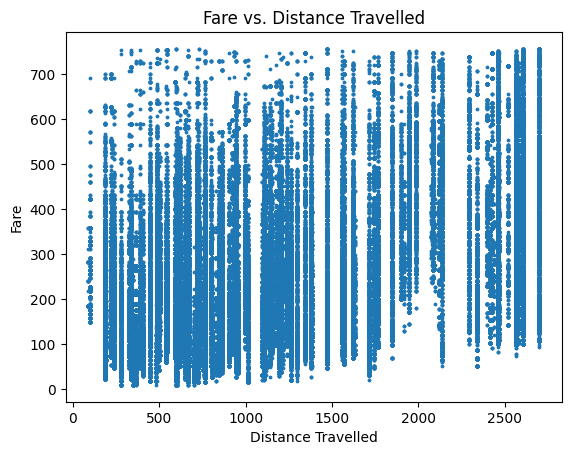

In [32]:
# Focussing on non-stop flights
df_nonstop = df[df["isNonStop"] == True]

# Plot fares against distance traveled
plt.scatter(df_nonstop["totalTravelDistance"], df_nonstop["baseFare"], s=3)
plt.xlabel("Distance Travelled")
plt.ylabel("Fare")
plt.title("Fare vs. Distance Travelled")

Text(0.5, 1.0, 'Average Fare vs. Distance Travelled')

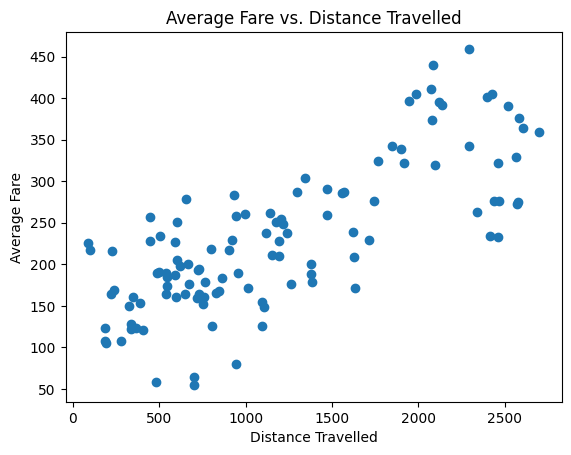

In [33]:
# Plot mean of fares for each distance
mean_fares = df_nonstop.groupby("totalTravelDistance")["baseFare"].mean()
plt.scatter(mean_fares.index, mean_fares)
plt.xlabel("Distance Travelled")
plt.ylabel("Average Fare")
plt.title("Average Fare vs. Distance Travelled")

### Simple regression analysis of fares on distances

In [34]:
class SimpleLinearRegression:

    def __init__(self):
        self.beta0 = None
        self.beta1 = None

    def fit(self, X, y):
        xbar = np.mean(X)
        ybar = np.mean(y)

        self.beta1 = sum((X-xbar)*(y-ybar)) / sum((X-xbar)**2)
        self.beta0 = ybar - (self.beta1 * xbar)
        return self
    
    def predict(self, X):
        return self.beta0 + (self.beta1 * X)
    
def sse(ytrue, ypred):
    return sum((ytrue - ypred) ** 2)

def mape(ytrue, ypred):
    return sum(abs(ytrue - ypred) / ytrue) * 100 / len(ytrue)

In [35]:
slr = SimpleLinearRegression()
X, y = mean_fares.index, mean_fares
slr.fit(X, y)
ypred = slr.predict(X)
print(f"beta0: {slr.beta0}, beta1: {slr.beta1}")
print(f"SSE: {sse(y, ypred)}, MAPE: {mape(y, ypred)}%")

beta0: 123.13056576497011, beta1: 0.09058624949954486
SSE: 366410.16613433236, MAPE: 24.92918476334815%


## Predicting ticket fares using Multiple Linear Regression

In [36]:
class MultipleLinearRegression:

    def __init__(self):
        self.beta = None

    def fit(self, X, y):
        # add a column of 1s
        n = X.shape[0]
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        X = np.concatenate([np.ones((n, 1)), X], axis=1)
        self.beta = np.linalg.pinv(X.T @ X) @ X.T @ y  # to deal with singular matrix issues
        return self
    
    def predict(self, X):
        # add a column of 1s
        n = X.shape[0]
        if not isinstance(X, np.ndarray):
            X = X.to_numpy()
        X = np.concatenate([np.ones((n, 1)), X], axis=1)
        return X @ self.beta

In [37]:
features_to_use = [
    "totalFare",  # target variable
    "baseFare",
    "seatsRemaining",
    "elapsedDays",
    "segmentsDurationInSeconds",
    "segmentsDistance",
    "segmentsDepartureTimeEpochSeconds",
    "segmentsArrivalTimeEpochSeconds",
    "travelDuration"
]
# only include nonstop flights and above features
df = df[df["isNonStop"] == True][features_to_use].dropna()

# clean data, convert objects to numeric types (makes calculations much faster)
df["travelDuration"] = df["travelDuration"].map(lambda x: convertTravelDurationToHours(x))
df.iloc[:,4:-1] = df.iloc[:,4:-1].astype(int)
df = df.infer_objects()
df.head()

,totalFare,baseFare,seatsRemaining,elapsedDays,segmentsDurationInSeconds,segmentsDistance,segmentsDepartureTimeEpochSeconds,segmentsArrivalTimeEpochSeconds,travelDuration
3,202.60,174.88,7,0,8580,725,1650189900,1650198480,2.383333
11,378.60,338.60,1,0,6660,541,1650216240,1650222900,1.850000
16,498.60,450.23,9,0,16980,1919,1650244320,1650261300,4.716667
19,193.99,166.87,4,0,7740,762,1650196260,1650204000,2.150000
20,198.60,171.16,7,0,8340,762,1650206400,1650214740,2.316667


In [38]:
def corrcoef(x, y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    ximxb = x - xbar
    yimyb = y - ybar
    return np.sum(ximxb * yimyb) / (np.sqrt(np.sum(ximxb ** 2)) * np.sqrt(np.sum(yimyb ** 2)))

In [39]:
# Compute the correlation coeffecient between each of the features and totalFare
for i in features_to_use[1:]:
    print(f"Correlation Coefficient between totalFare and {i}: ", end="")
    print(corrcoef(df["totalFare"], df[i]))

Correlation Coefficient between totalFare and baseFare: 0.9999943593629081
Correlation Coefficient between totalFare and seatsRemaining: -0.05517505255740284
Correlation Coefficient between totalFare and elapsedDays: 0.1127824383022832
Correlation Coefficient between totalFare and segmentsDurationInSeconds: 0.5190949345542499
Correlation Coefficient between totalFare and segmentsDistance: 0.5387799932138779
Correlation Coefficient between totalFare and segmentsDepartureTimeEpochSeconds: -0.20177265917892476
Correlation Coefficient between totalFare and segmentsArrivalTimeEpochSeconds: -0.2011585013076021
Correlation Coefficient between totalFare and travelDuration: 0.5190949345542496


Based on correlation coefficient alone, we can use **baseFare**, **segmentsDurationInSeconds**, **segmentsDistance**, and **travelDuration**, since they all have absolute correlation coefficients that are greater than 0.5.

In [40]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [41]:
chosen_features = [
    "baseFare",
    "segmentsDurationInSeconds",
    "segmentsDistance",
    "travelDuration"
]
for i in range(len(chosen_features)-1):
    for j in range(i+1, len(chosen_features)):
        print(f"Cosine similarity between {chosen_features[i]} and {chosen_features[j]}: {cosine_similarity(df[chosen_features[i]], df[chosen_features[j]])}")

Cosine similarity between baseFare and segmentsDurationInSeconds: 0.8967449345477
Cosine similarity between baseFare and segmentsDistance: 0.8710319511816996
Cosine similarity between baseFare and travelDuration: 0.8967449345476937
Cosine similarity between segmentsDurationInSeconds and segmentsDistance: 0.985454910280702
Cosine similarity between segmentsDurationInSeconds and travelDuration: 0.9999999999999943
Cosine similarity between segmentsDistance and travelDuration: 0.9854549102806971


Using an arbitrary similarity threshold of 0.95 (set high because we only want to drop features that are **very** similar), we can drop either segmentsDurationInSeconds, segmentsDistance, or travelDuration, since those 3 are all very similar to each other. We arbitrarily chose to keep travelDuration.

In [42]:
def train_test_split(X, y, train_size, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    idxs = np.random.choice(X.index, int(len(X)*train_size), replace=False)
    return X[X.index.isin(idxs)], X[~X.index.isin(idxs)], y[X.index.isin(idxs)], y[~X.index.isin(idxs)]

In [43]:
# Train MLR model with all 8 features
chosen_features = [
    "baseFare",
    "travelDuration"
]
mlr = MultipleLinearRegression()
X, y = df.drop("totalFare", axis=1), df["totalFare"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
mlr.fit(X_train, y_train)

ypred = mlr.predict(X_train)
train_sse = sse(y_train, ypred)

ypred = mlr.predict(X_test)
test_sse = sse(y_test, ypred)
print(f"Train SSE: {train_sse}, Test SSE: {test_sse}")

Train SSE: 140047.9902734899, Test SSE: 59187.77611722392


In [44]:
X, y = df[chosen_features], df["totalFare"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)
mlr.fit(X_train, y_train)

ypred = mlr.predict(X_train)
train_sse2 = sse(y_train, ypred)

ypred = mlr.predict(X_test)
test_sse2 = sse(y_test, ypred)
print(f"Train SSE: {train_sse2}, Test SSE: {test_sse2}")

Train SSE: 138411.8016307587, Test SSE: 58481.94918368566


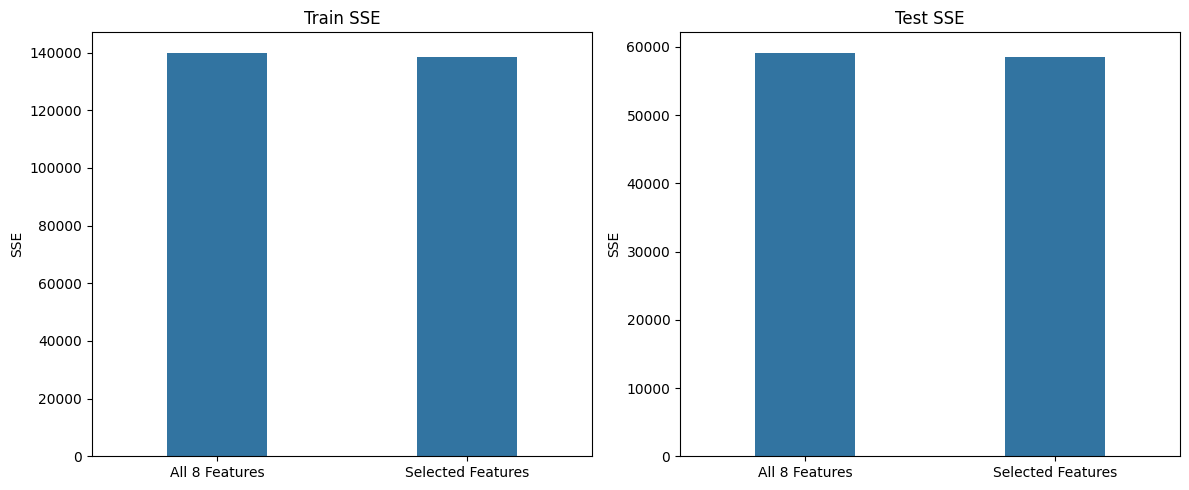

In [45]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=["All 8 Features", "Selected Features"], y=[train_sse, train_sse2], gap=0.5)
plt.title("Train SSE")
plt.ylabel("SSE")

plt.subplot(1, 2, 2)
sns.barplot(x=["All 8 Features", "Selected Features"], y=[test_sse, test_sse2], gap=0.5)
plt.title("Test SSE")
plt.ylabel("SSE")
plt.tight_layout()

# Part C

In [46]:
# Load full data again
df = pd.read_table("split_00.txt", sep=",")

## JFK to ORD

In [47]:
df1 = df[(df["startingAirport"] == "JFK") & (df["destinationAirport"] == "ORD")]

### Plot average fare for each day

Text(0.5, 1.0, 'Average Fare Per Day')

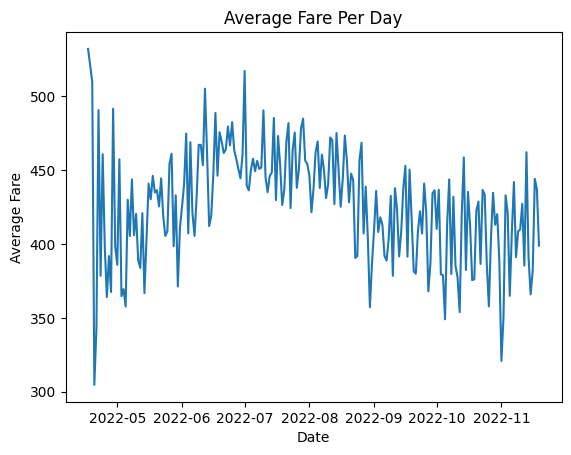

In [48]:
# Extract flightDate and totalFare for all flights in the dataset
df1.loc[:,"flightDate"] = pd.to_datetime(df1["flightDate"])
flight_date, total_fare = df1["flightDate"], df1["totalFare"]

# Find average fare for each day
avg_fare_per_day = df1.groupby(flight_date)["totalFare"].mean()

# Plot average fare vs date
plt.plot(avg_fare_per_day)
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.title("Average Fare Per Day")

### AR(k) analysis for k = 3 to 10

In [49]:
# Perform an AR(k) analysis on the average fares with k = 3 to 10
mlr = MultipleLinearRegression()
preds = {}
true = {}
for k in range(3, 11):
    pred_k = []
    true_k = []
    for i in range(15, len(avg_fare_per_day)-k-1):
        X_train = np.zeros((i-k, k))
        y_train = np.zeros((i-k, 1))
        for j in range(i-k):
            X_train[j] = avg_fare_per_day[j:j+k]
            y_train[j] = avg_fare_per_day.iloc[j+k]
        mlr.fit(X_train, y_train)
        pred_k.append(mlr.predict(X_train[-1].reshape(1, -1)))
        true_k.append(avg_fare_per_day.iloc[i])
    preds[k] = np.array(pred_k).squeeze()
    true[k] = np.array(true_k)
    print(f"k={k} -- SSE: {sse(preds[k], true[k])}, MAPE: {mape(preds[k], true[k])}%")

k=3 -- SSE: 201347.03300377543, MAPE: 5.9713051460385875%
k=4 -- SSE: 192123.47900865716, MAPE: 5.7807690620642775%
k=5 -- SSE: 179939.0573622435, MAPE: 5.757102414533359%
k=6 -- SSE: 169591.724482706, MAPE: 5.6087191862308465%
k=7 -- SSE: 184733.9538908568, MAPE: 5.85582342243912%
k=8 -- SSE: 188371.04552663385, MAPE: 5.880085724597804%
k=9 -- SSE: 199043.65217103556, MAPE: 6.131254377264359%
k=10 -- SSE: 199907.75380260404, MAPE: 6.137246269864149%


Text(0, 0.5, 'MAPE (%)')

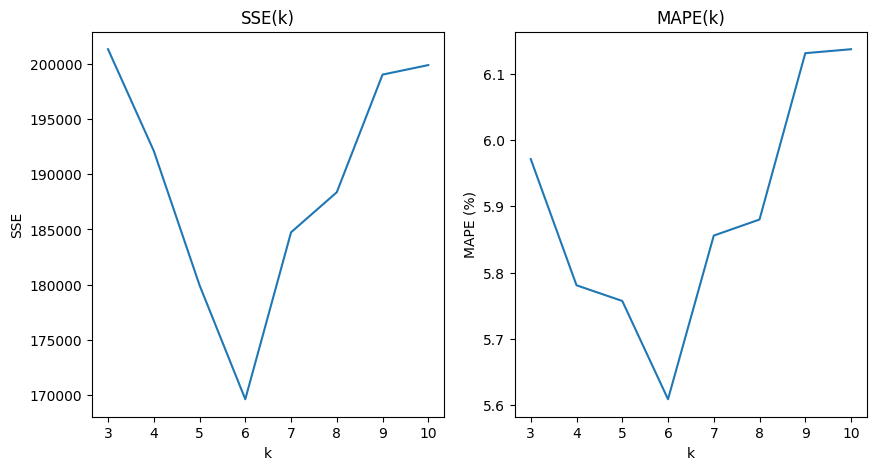

In [50]:
# Plot SSE and MAPE from AR(k) analysis
sses = [sse(t, p) for t, p in zip(preds.values(), true.values())]
mapes = [mape(t, p) for t, p in zip(preds.values(), true.values())]
ks = list(range(3, 11))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ks, sses)
plt.title("SSE(k)")
plt.xlabel("k")
plt.ylabel("SSE")

plt.subplot(1, 2, 2)
plt.plot(ks, mapes)
plt.title("MAPE(k)")
plt.xlabel("k")
plt.ylabel("MAPE (%)")

k=6 works well, using the past 6 days to predict perhaps shows weekly seasonality

### EWMA analysis for $\alpha=0.5$ and $\alpha=0.8$

In [51]:
# Perform EWMA for alpha=0.5 and alpha=0.8
preds = {}
true = {}
for alpha in [0.5, 0.8]:
    pred_alpha = []
    true_alpha = []
    yt = avg_fare_per_day.iloc[0]
    for i in range(1, len(avg_fare_per_day)-k-1):
        yt = alpha * avg_fare_per_day.iloc[i] + (1-alpha) * yt
        if i >= 15:
            pred_alpha.append(yt)
            true_alpha.append(avg_fare_per_day.iloc[i])
    preds[alpha] = np.array(pred_alpha)
    true[alpha] = np.array(true_alpha)
    print(f"alpha={alpha} -- SSE: {sse(preds[alpha], true[alpha])}, MAPE: {mape(preds[alpha], true[alpha])}%")

alpha=0.5 -- SSE: 43295.634797242485, MAPE: 2.9615052128555313%
alpha=0.8 -- SSE: 8129.411842359965, MAPE: 1.2836474338318637%


$\alpha$ = 0.8 works well using the EWMA method. In fact, it works even better than the best AR method by SSE (8129 vs 169592) and by MAPE (1.28% vs 5.61%). 

### Same analysis as before, but using average fare per week

Text(0.5, 1.0, 'Average Fare Per Week')

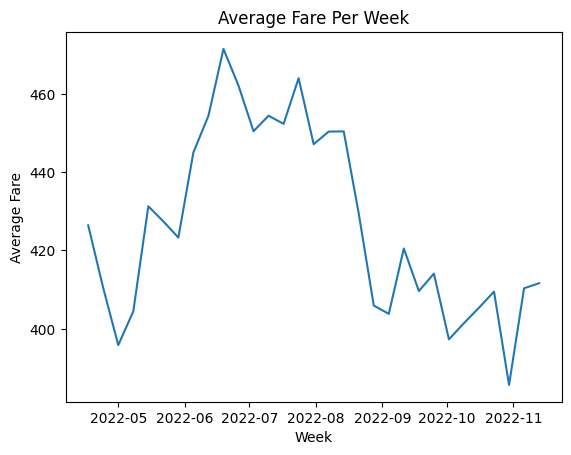

In [52]:
# Find and plot average fare by week
avg_fare_per_week = avg_fare_per_day.resample("W", label="left", closed="left").mean()

plt.plot(avg_fare_per_week)
plt.xlabel("Week")
plt.ylabel("Average Fare")
plt.title("Average Fare Per Week")

In [53]:
# AR(k) analysis with k = 2 to 4
preds = {}
true = {}
for k in range(2, 5):
    pred_k = []
    true_k = []
    for i in range(5, len(avg_fare_per_week)-k-1):
        X_train = np.zeros((i-k, k))
        y_train = np.zeros((i-k, 1))
        for j in range(i-k):
            X_train[j] = avg_fare_per_week[j:j+k]
            y_train[j] = avg_fare_per_week.iloc[j+k]
        mlr.fit(X_train, y_train)
        pred_k.append(mlr.predict(X_train[-1].reshape(1, -1)))
        true_k.append(avg_fare_per_week.iloc[i])
    preds[k] = np.array(pred_k).squeeze()
    true[k] = np.array(true_k)
    print(f"k={k} -- SSE: {sse(preds[k], true[k])}, MAPE: {mape(preds[k], true[k])}%")

k=2 -- SSE: 7014.414723723558, MAPE: 3.142886890547294%
k=3 -- SSE: 5642.687822734801, MAPE: 2.8224291603025016%
k=4 -- SSE: 5417.66337746549, MAPE: 2.948480604029064%


k=2 or 3 are ok -- k=2 if using mape, k=3 if using sse

Text(0, 0.5, 'MAPE (%)')

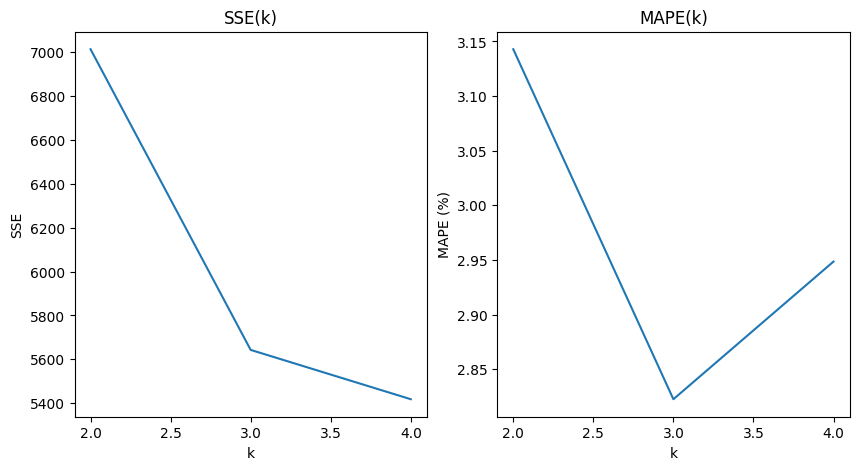

In [54]:
# Plot SSE and MAPE from AR(k) analysis
sses = [sse(t, p) for t, p in zip(preds.values(), true.values())]
mapes = [mape(t, p) for t, p in zip(preds.values(), true.values())]
ks = list(range(2, 5))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ks, sses)
plt.title("SSE(k)")
plt.xlabel("k")
plt.ylabel("SSE")

plt.subplot(1, 2, 2)
plt.plot(ks, mapes)
plt.title("MAPE(k)")
plt.xlabel("k")
plt.ylabel("MAPE (%)")

In [55]:
# Perform EWMA for alpha=0.5 and alpha=0.8
preds = {}
true = {}
for alpha in [0.5, 0.8]:
    pred_alpha = []
    true_alpha = []
    yt = avg_fare_per_week.iloc[0]
    for i in range(1, len(avg_fare_per_week)-k-1):
        yt = alpha * avg_fare_per_week.iloc[i] + (1-alpha) * yt
        if i >= 5:
            pred_alpha.append(yt)
            true_alpha.append(avg_fare_per_week.iloc[i])
    preds[alpha] = np.array(pred_alpha)
    true[alpha] = np.array(true_alpha)
    print(f"alpha={alpha} -- SSE: {sse(preds[alpha], true[alpha])}, MAPE: {mape(preds[alpha], true[alpha])}%")

alpha=0.5 -- SSE: 1120.5739386047262, MAPE: 1.274851408873889%
alpha=0.8 -- SSE: 135.85245990542575, MAPE: 0.4543595114159783%


$\alpha=0.8$ performs the best in this case, with lowest SSE and MAPE

In [56]:
# backup the avg fare per day for this route
jfk_ord_avg_fare = avg_fare_per_day

## LAX to ATL

In [57]:
df2 = df[(df["startingAirport"] == "LAX") & (df["destinationAirport"] == "ATL")]

### Plot average fare for each day

Text(0.5, 1.0, 'Average Fare Per Day')

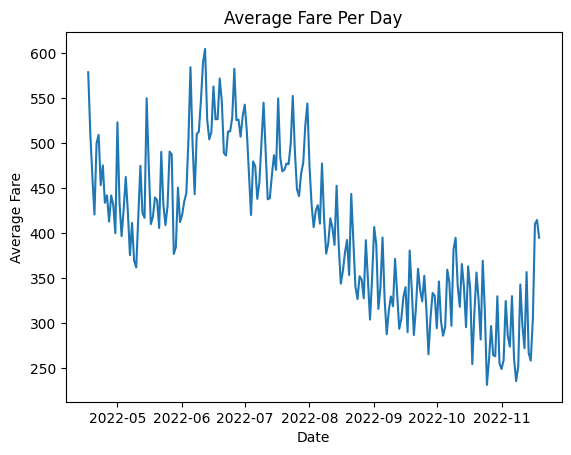

In [58]:
# Extract flightDate and totalFare for all flights in the dataset
df2.loc[:,"flightDate"] = pd.to_datetime(df2["flightDate"])
flight_date, total_fare = df2["flightDate"], df2["totalFare"]

# Find average fare for each day
avg_fare_per_day = df2.groupby(flight_date)["totalFare"].mean()

# Plot average fare vs date
plt.plot(avg_fare_per_day)
plt.xlabel("Date")
plt.ylabel("Average Fare")
plt.title("Average Fare Per Day")

### AR(k) analysis for k = 3 to 10

In [59]:
# Perform an AR(k) analysis on the average fares with k = 3 to 10
mlr = MultipleLinearRegression()
preds = {}
true = {}
for k in range(3, 11):
    pred_k = []
    true_k = []
    for i in range(15, len(avg_fare_per_day)-k-1):
        X_train = np.zeros((i-k, k))
        y_train = np.zeros((i-k, 1))
        for j in range(i-k):
            X_train[j] = avg_fare_per_day[j:j+k]
            y_train[j] = avg_fare_per_day.iloc[j+k]
        mlr.fit(X_train, y_train)
        pred_k.append(mlr.predict(X_train[-1].reshape(1, -1)))
        true_k.append(avg_fare_per_day.iloc[i])
    preds[k] = np.array(pred_k).squeeze()
    true[k] = np.array(true_k)
    print(f"k={k} -- SSE: {sse(preds[k], true[k])}, MAPE: {mape(preds[k], true[k])}%")

k=3 -- SSE: 474796.988497595, MAPE: 9.673063895156092%
k=4 -- SSE: 463135.43018765043, MAPE: 9.668288985429012%
k=5 -- SSE: 455272.2574641441, MAPE: 9.546299870112197%
k=6 -- SSE: 403565.1798058056, MAPE: 8.874913110289357%
k=7 -- SSE: 458538.4073997059, MAPE: 9.734222702148271%
k=8 -- SSE: 472181.766996915, MAPE: 10.133966111993344%
k=9 -- SSE: 469036.4619169908, MAPE: 9.984682781086462%
k=10 -- SSE: 458916.0017375483, MAPE: 9.929329329532129%


k=6 is best here since it yields the lowest SSE and MAPE

Text(0, 0.5, 'MAPE (%)')

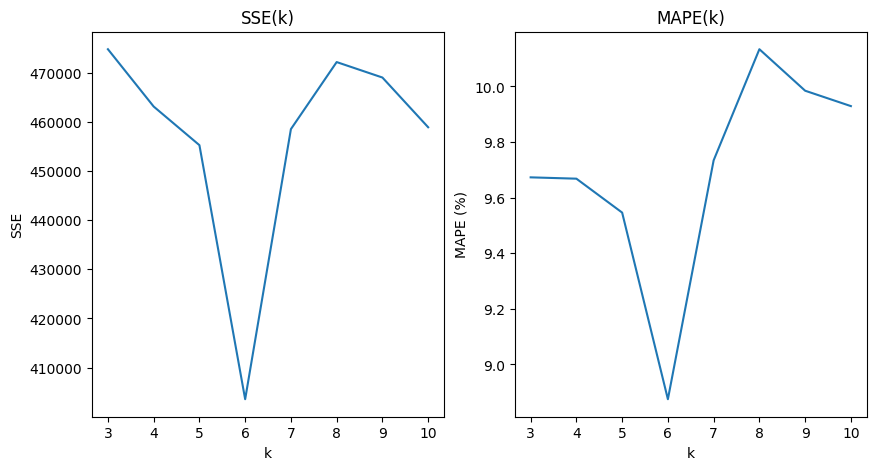

In [60]:
# Plot SSE and MAPE from AR(k) analysis
sses = [sse(t, p) for t, p in zip(preds.values(), true.values())]
mapes = [mape(t, p) for t, p in zip(preds.values(), true.values())]
ks = list(range(3, 11))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ks, sses)
plt.title("SSE(k)")
plt.xlabel("k")
plt.ylabel("SSE")

plt.subplot(1, 2, 2)
plt.plot(ks, mapes)
plt.title("MAPE(k)")
plt.xlabel("k")
plt.ylabel("MAPE (%)")

### EWMA analysis for $\alpha=0.5$ and $\alpha=0.8$

In [61]:
# Perform EWMA for alpha=0.5 and alpha=0.8
preds = {}
true = {}
for alpha in [0.5, 0.8]:
    pred_alpha = []
    true_alpha = []
    yt = avg_fare_per_day.iloc[0]
    for i in range(1, len(avg_fare_per_day)-k-1):
        yt = alpha * avg_fare_per_day.iloc[i] + (1-alpha) * yt
        if i >= 15:
            pred_alpha.append(yt)
            true_alpha.append(avg_fare_per_day.iloc[i])
    preds[alpha] = np.array(pred_alpha)
    true[alpha] = np.array(true_alpha)
    print(f"alpha={alpha} -- SSE: {sse(preds[alpha], true[alpha])}, MAPE: {mape(preds[alpha], true[alpha])}%")

alpha=0.5 -- SSE: 80952.80186919296, MAPE: 4.240269195257776%
alpha=0.8 -- SSE: 14446.231611438756, MAPE: 1.8688524171380627%


$\alpha = 0.8$ works well, yielding the lowest SSE and MAPE

### Same analysis as before, but using average fare per week

Text(0.5, 1.0, 'Average Fare Per Week')

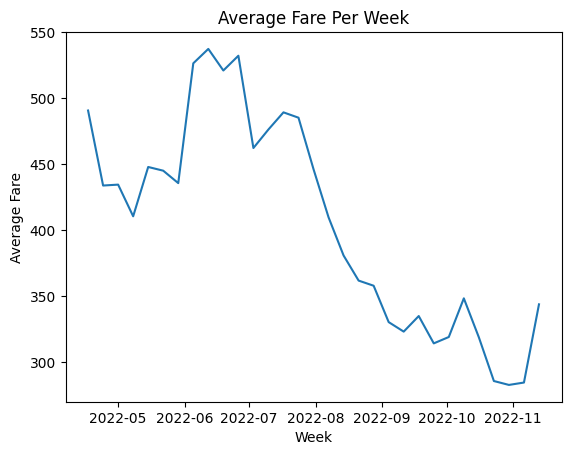

In [62]:
# Find and plot average fare by week
avg_fare_per_week = avg_fare_per_day.resample("W", label="left", closed="left").mean()

plt.plot(avg_fare_per_week)
plt.xlabel("Week")
plt.ylabel("Average Fare")
plt.title("Average Fare Per Week")

In [63]:
# AR(k) analysis with k = 2 to 4
preds = {}
true = {}
for k in range(2, 5):
    pred_k = []
    true_k = []
    for i in range(5, len(avg_fare_per_week)-k-1):
        X_train = np.zeros((i-k, k))
        y_train = np.zeros((i-k, 1))
        for j in range(i-k):
            X_train[j] = avg_fare_per_week[j:j+k]
            y_train[j] = avg_fare_per_week.iloc[j+k]
        mlr.fit(X_train, y_train)
        pred_k.append(mlr.predict(X_train[-1].reshape(1, -1)))
        true_k.append(avg_fare_per_week.iloc[i])
    preds[k] = np.array(pred_k).squeeze()
    true[k] = np.array(true_k)
    print(f"k={k} -- SSE: {sse(preds[k], true[k])}, MAPE: {mape(preds[k], true[k])}%")

k=2 -- SSE: 46234.97329547049, MAPE: 8.312005269688262%
k=3 -- SSE: 40522.808589143104, MAPE: 7.780966372413622%
k=4 -- SSE: 40528.70290654195, MAPE: 7.607365068018047%


k=3 or 4 are both fine, a case can be made for k=3 if using SSE, but k=4 is fine too if using MAPE

Text(0, 0.5, 'MAPE (%)')

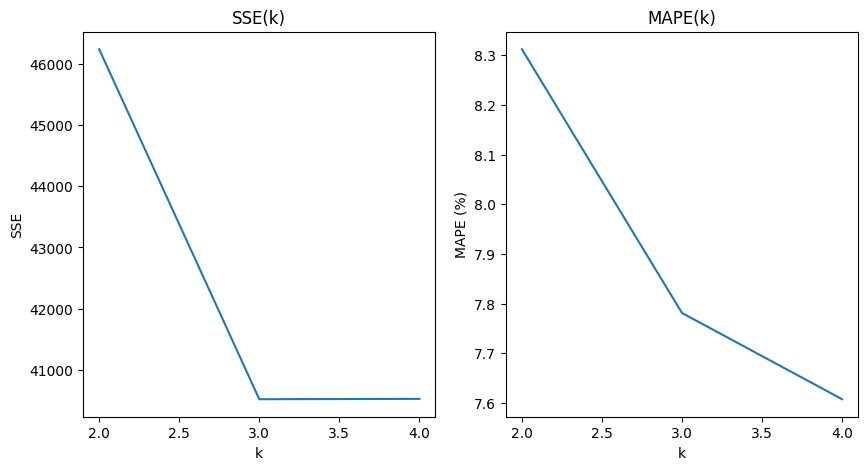

In [64]:
# Plot SSE and MAPE from AR(k) analysis
sses = [sse(t, p) for t, p in zip(preds.values(), true.values())]
mapes = [mape(t, p) for t, p in zip(preds.values(), true.values())]
ks = list(range(2, 5))

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(ks, sses)
plt.title("SSE(k)")
plt.xlabel("k")
plt.ylabel("SSE")

plt.subplot(1, 2, 2)
plt.plot(ks, mapes)
plt.title("MAPE(k)")
plt.xlabel("k")
plt.ylabel("MAPE (%)")

In [65]:
# Perform EWMA for alpha=0.5 and alpha=0.8
preds = {}
true = {}
for alpha in [0.5, 0.8]:
    pred_alpha = []
    true_alpha = []
    yt = avg_fare_per_week.iloc[0]
    for i in range(1, len(avg_fare_per_week)-k-1):
        yt = alpha * avg_fare_per_week.iloc[i] + (1-alpha) * yt
        if i >= 5:
            pred_alpha.append(yt)
            true_alpha.append(avg_fare_per_week.iloc[i])
    preds[alpha] = np.array(pred_alpha)
    true[alpha] = np.array(true_alpha)
    print(f"alpha={alpha} -- SSE: {sse(preds[alpha], true[alpha])}, MAPE: {mape(preds[alpha], true[alpha])}%")

alpha=0.5 -- SSE: 7522.055149081551, MAPE: 3.4960013480441297%
alpha=0.8 -- SSE: 878.847409699819, MAPE: 1.1061660698306912%


$\alpha=0.8$ is best here since it yields the lowest SSE and MAPE

## Differences between both routes

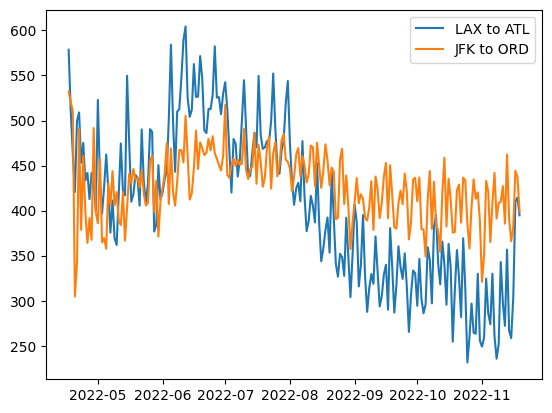

In [66]:
plt.plot(avg_fare_per_day, label="LAX to ATL")
plt.plot(jfk_ord_avg_fare, label="JFK to ORD")
plt.legend()
plt.show()